# Fitting COVID19 trends using Bayesian method

In this assignment, our goal is to fit the COVID 19 trends (confirmed cases of COVID 19 as a function of date) using the generalized growth model given by

\begin{align}
\frac{d C(t)}{dt} = r C(t)^p, \label{eq:ode} \tag{1}
\end{align}

where $t \in [0,T]$ is the time (in units of days), $r \geq 0$ is the growth rate, $p
\in [0,1]$ is the 'decceleration of growth' parameter, see **Viboud et al 2015**. Special cases: $p = 0$ gives linear growth model and $p=1$ gives exponential growth model. 

$C : [0,T] \to [0, \infty)$ is the total confirmed COVID 19 cases at time $t$. When $0 < p < 1$, Eq (1) can be solved to get 

\begin{align}
C(t) = \left( \frac{r}{m}t + (C_0)^{1/m} \right)^m, \label{eq:model} \tag{2}
\end{align}

where $m = 1/(1 - p)$ and $C_0 = C(0)$ is the initial condition. For special cases $p=0$ and $p=1$, $C$ can be found easily.

# Problem

We cosider COVID 19 data at discrete times $\bar{t} = (t_1=0, t_2=1, ..., t_N=83)$, where $N = 84$, and corresponding total confirmed cases $Y(\bar{t}) = (Y_1, Y_2, ..., Y_N)$.

Model prediction is $C(\bar{t}) = (C(t_1), C(t_2), ..., C(t_N))$ where $C(t_i)$ is given by Eq (2). The model parameters are $\theta = (r, p)$. Take uniform prior for $\theta$ and consider a Guassian noise with zero mean and standard deviation $\sigma$. Divide the data in calibration and validation by taking first $N_c = 50$ as the calibration data and rest $N_v = N - N_c$ as validation data. You can also try different priors for parameters and divide data differently in calibration and validation set.

Problem: Predict the total confirmed cases at $T = 100$ day for three countries US, Japan, and South Korea.

# Data
Data for current epidemic COVID 19 can be found in several places such as:

- [datasets/covid-19](https://github.com/datasets/covid-19)

- [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

- [nytimes/covid-19-data](https://github.com/nytimes/covid-19-data)


In [StudyCovid19](https://github.com/prashjha/StudyCovid19) you will find python scripts to process data and this notebook in directory `process/bayesian`.


Below we plot the confirmed cases for various countries

# Load Data

Num days: 84


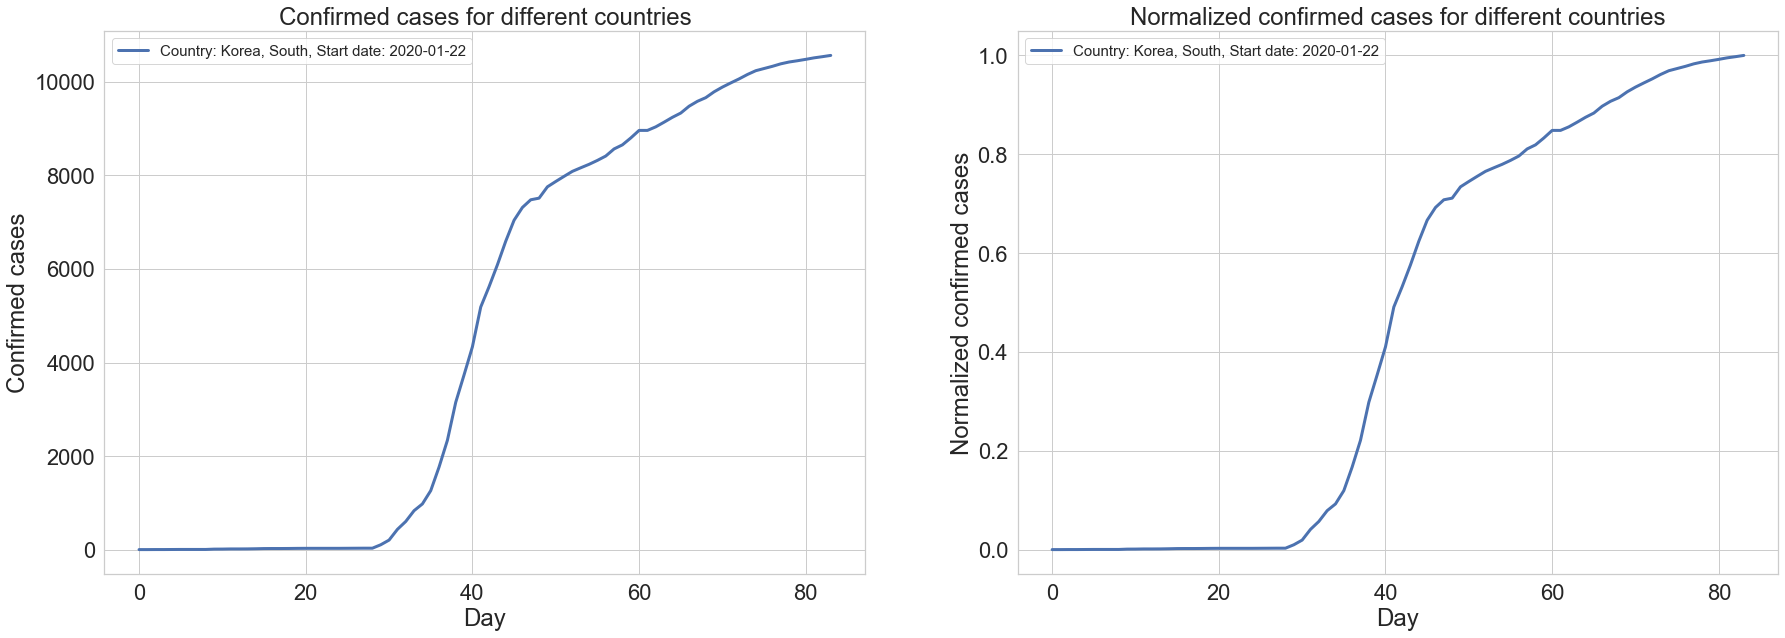

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../')
from sklearn.neighbors import KernelDensity
from data import plot_countries_all_plus_normalize_1 as plot
from data import save_country_data_1 as save
df = pd.read_csv('../../data/datasets/time-series-19-covid-combined.csv')
# plot
plot(df, ['Korea, South'])
# save data
save(df, ['Korea, South'])

# Data Setting

In [5]:
data = np.zeros([2,84])
data[0] = np.arange(84)
data[1] = np.array(df[df['Country/Region']=='Korea, South']['Confirmed'])
C0 = data[0,1]

# Model 3

In [6]:
def model_3(t, a, b, p):
    return a * np.exp(b*(1-1/(1-(1-t/100)**p)))+C0

# Prior Distribution for Calibration

In [7]:
#prior distribution
def prior_3(x):
    #x[0] = a, x[1]=b, x[2]=p (new or current)
    if(x[0] <= 1.e-5):
        return 1.e-8
    elif (x[1] <= 1.e-5):
        return 1.e-8
    elif (x[2] <= 1. + 1.e-5):
        return 1.e-8
    else:
        return 1.

# Likelihood Function

In [8]:
#likelihood function
def log_like_3(x,data):
    #x[0]=a, x[1]=b, x[2]=p (new or current)
    #data[0]=t, data[1]=C_obs(t)
    C = model_3(data[0],x[0],x[1],x[2])
    return (-1. / (2. * noise_sig * noise_sig)) * np.dot(data[1] - C,data[1] - C)

# MCMC-MH

In [9]:
#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))

def metropolis_hastings(likelihood_computer, prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    itr_a = []
    rejected = []
    itr_r = []
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
            itr_a.append(i)
        else:
            rejected.append(x_new)
            itr_r.append(i)
    return np.array(accepted), np.array(rejected), np.array(itr_a), np.array(itr_r)

# Calibration

In [40]:
transition_model_m3c = lambda x: np.random.normal(x,[100.,1.,0.1],(3,))
noise_sig = 500.
theta0_m3c = [0.1*np.max(data[1,:50]), 0.4, 4.]
accepted_m3c, rejected_m3c, itr_a_m3c, itr_r_m3c = metropolis_hastings(log_like_3,prior_3,transition_model_m3c,theta0_m3c,300000,data[:,:50],acceptance)

C:\Users\intm2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


C:\Users\intm2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


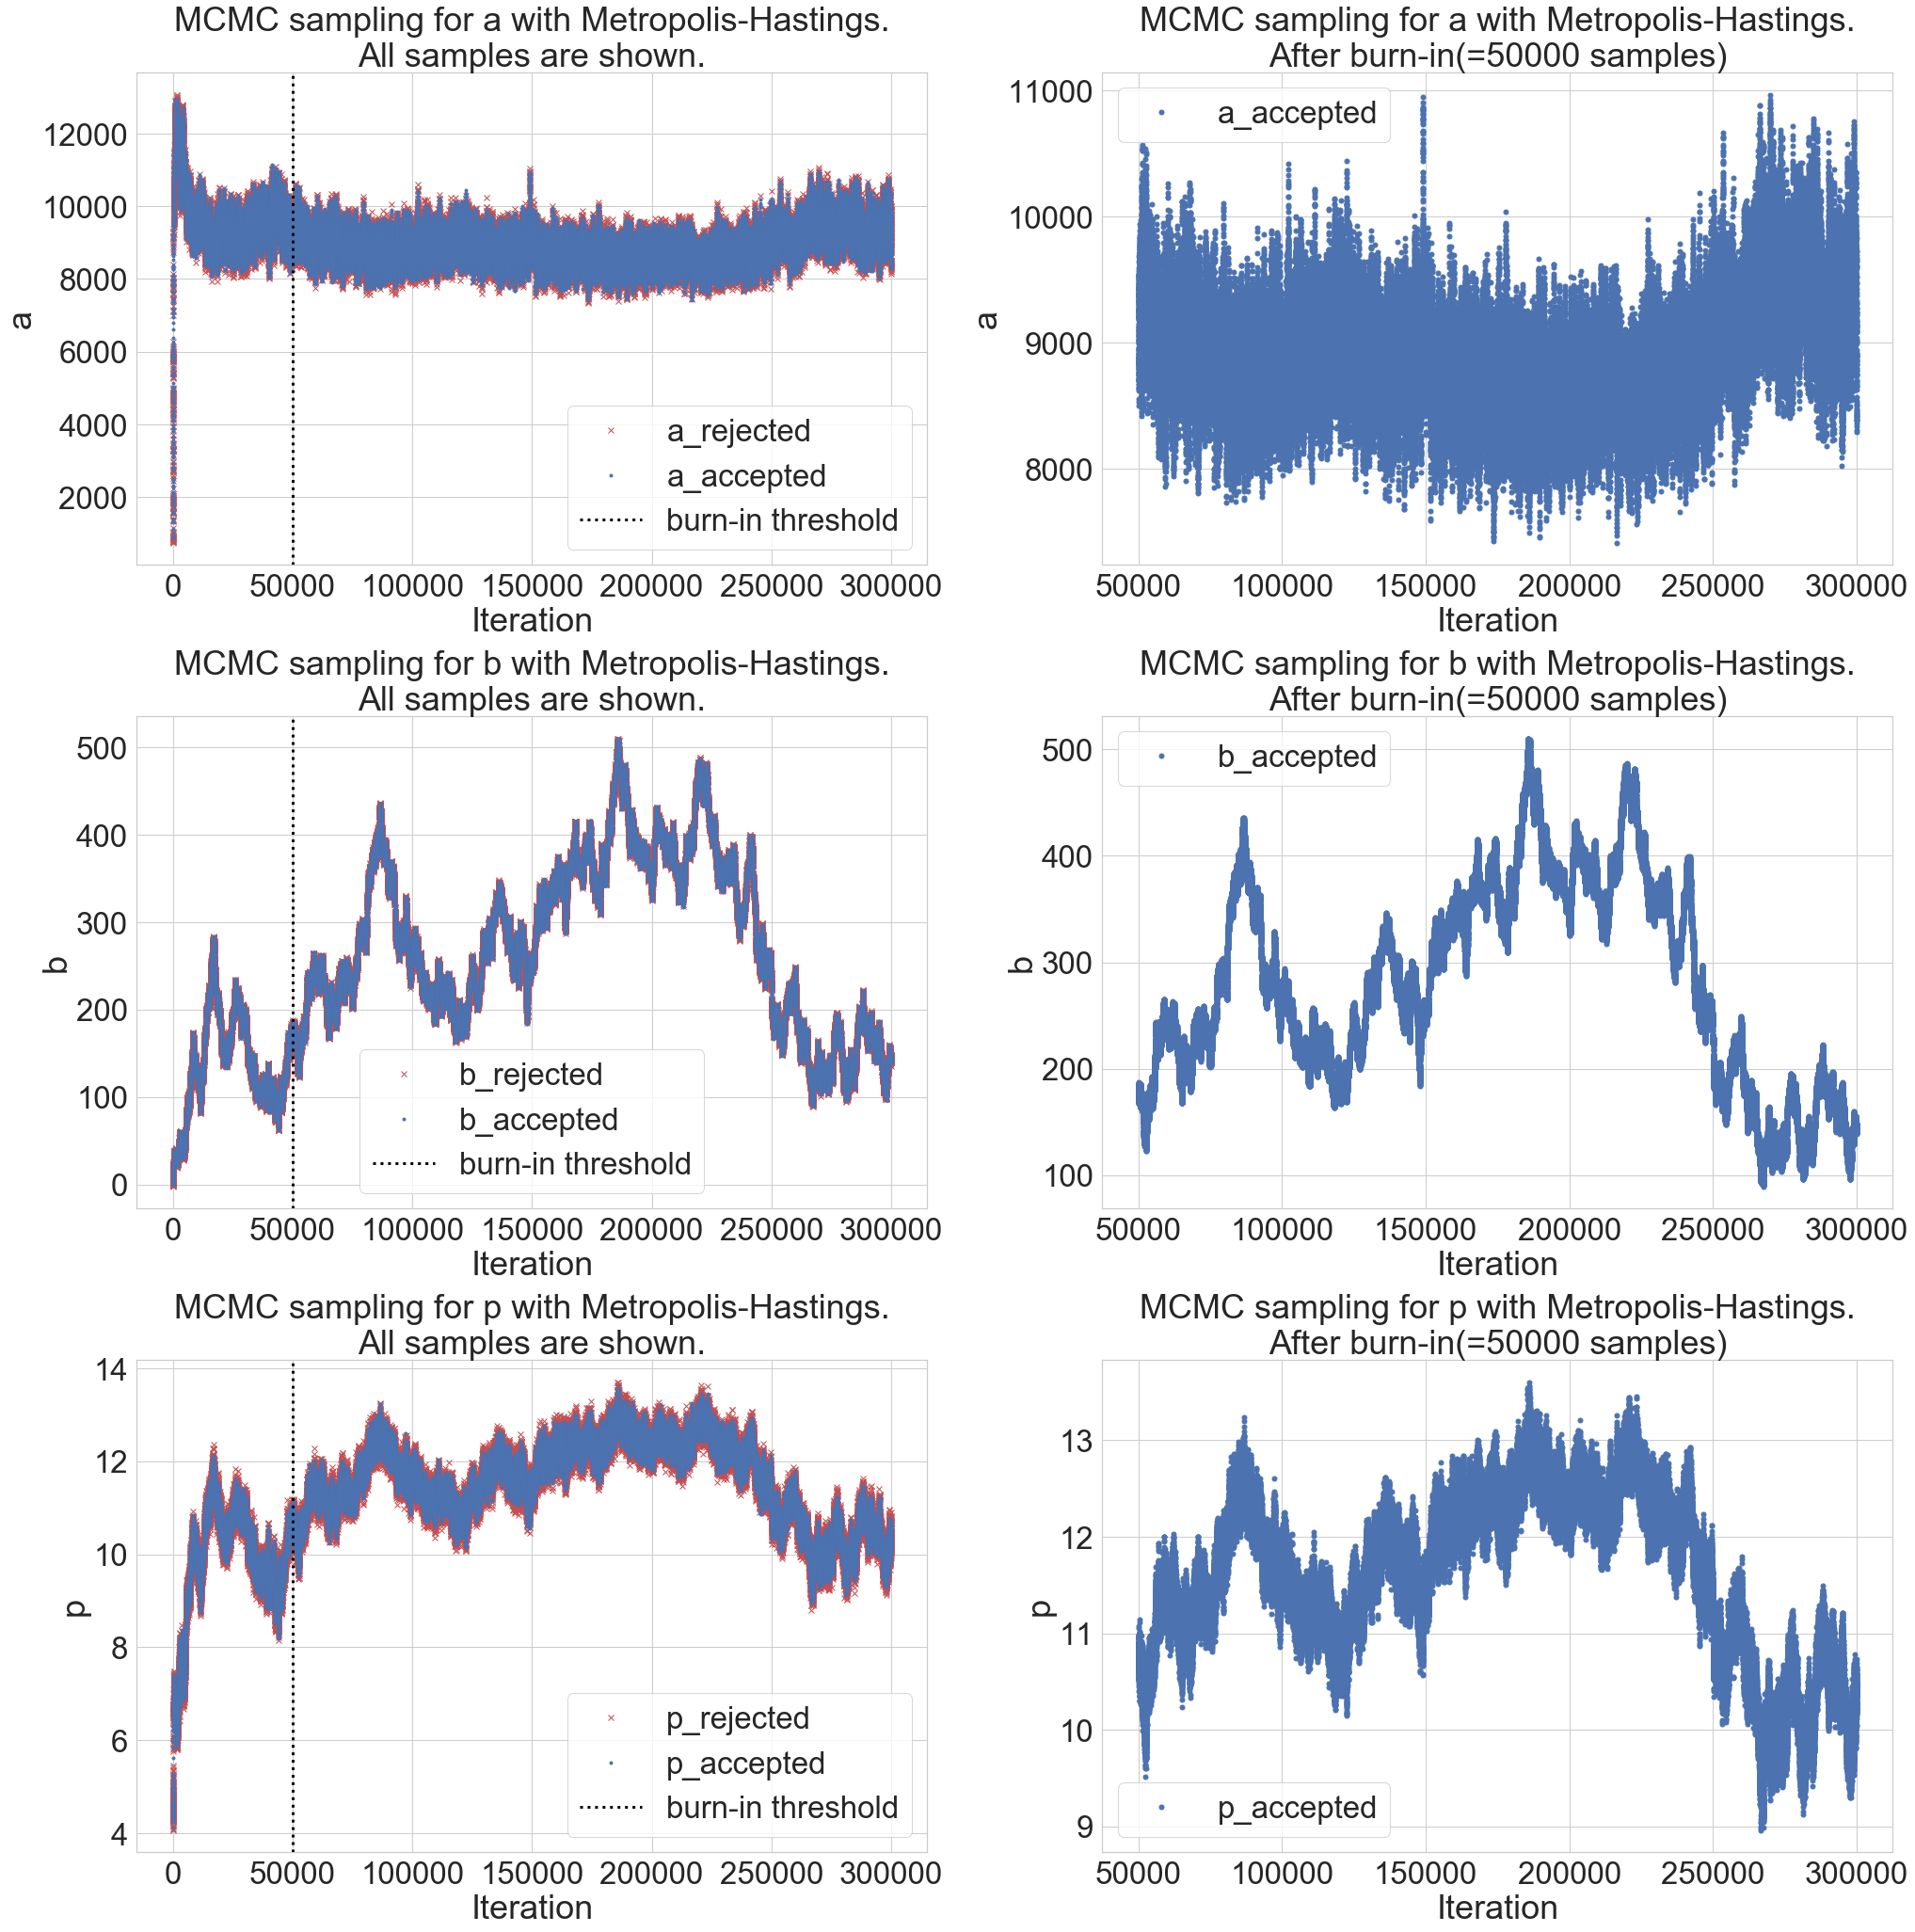

In [41]:
burnin = 50000
plot_MCMC_check_3(accepted_m3c, rejected_m3c, itr_a_m3c, itr_r_m3c, burnin)

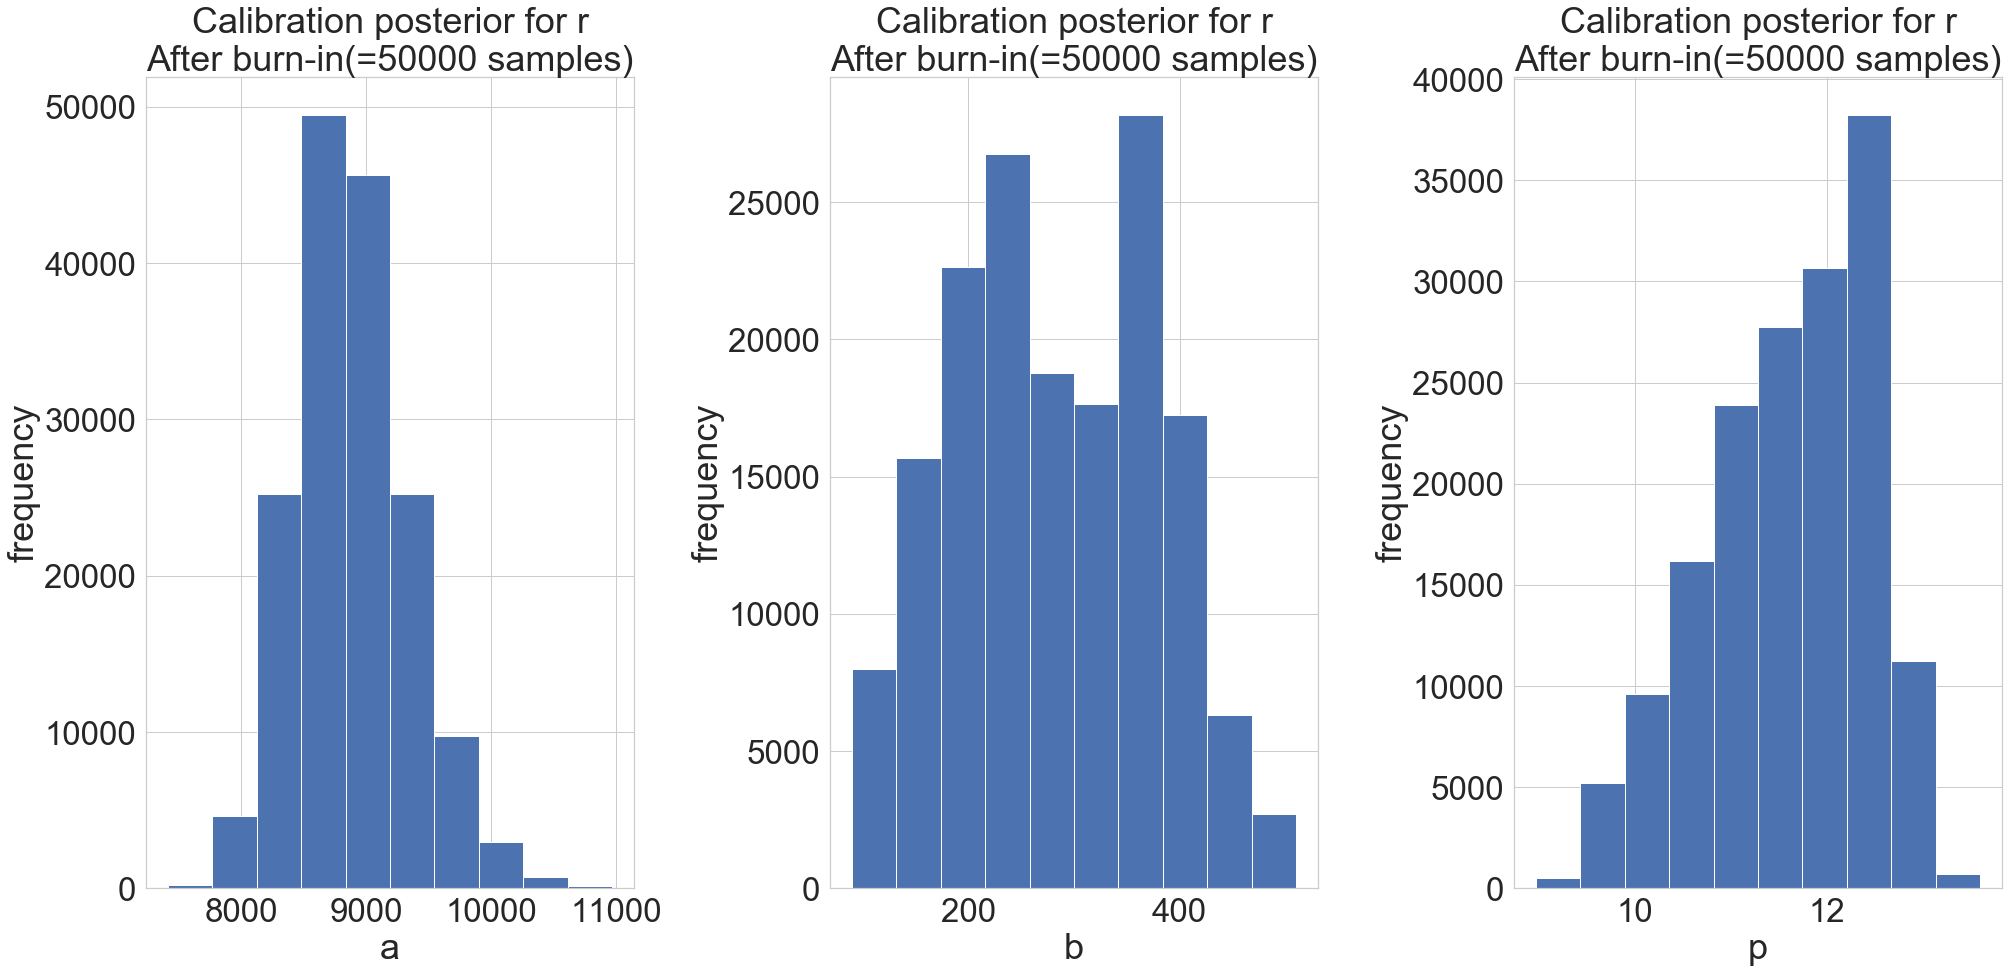

In [42]:
plot_posterior_3(accepted_m3c, itr_a_m3c, burnin, 0)

In [43]:
mu_m3c = [np.mean(accepted_m3c[np.where(itr_a_m3c>burnin)][:,0]),np.mean(accepted_m3c[np.where(itr_a_m3c>burnin)][:,1]),np.mean(accepted_m3c[np.where(itr_a_m3c>burnin)][:,2])]

# Kernel Density Estimation

In [44]:
kde_a = KernelDensity(bandwidth=3.,kernel='gaussian')
x = accepted_m3c[np.where(itr_a_m3c>burnin)][:,0]
kde_a.fit(x[:,None])
x_d_a = np.linspace(min(x),max(x),1000)
logprob_a = kde_a.score_samples(x_d_a[:,None])

In [45]:
kde_b = KernelDensity(bandwidth=1.,kernel='gaussian')
x = accepted_m3c[np.where(itr_a_m3c>burnin)][:,1]
kde_b.fit(x[:,None])
x_d_b = np.linspace(min(x),max(x),1000)
logprob_b = kde_b.score_samples(x_d_b[:,None])

In [46]:
kde_p = KernelDensity(bandwidth=0.01,kernel='gaussian')
x = accepted_m3c[np.where(itr_a_m3c>burnin)][:,2]
kde_p.fit(x[:,None])
x_d_p = np.linspace(min(x),max(x),1000)
logprob_p = kde_p.score_samples(x_d_p[:,None])

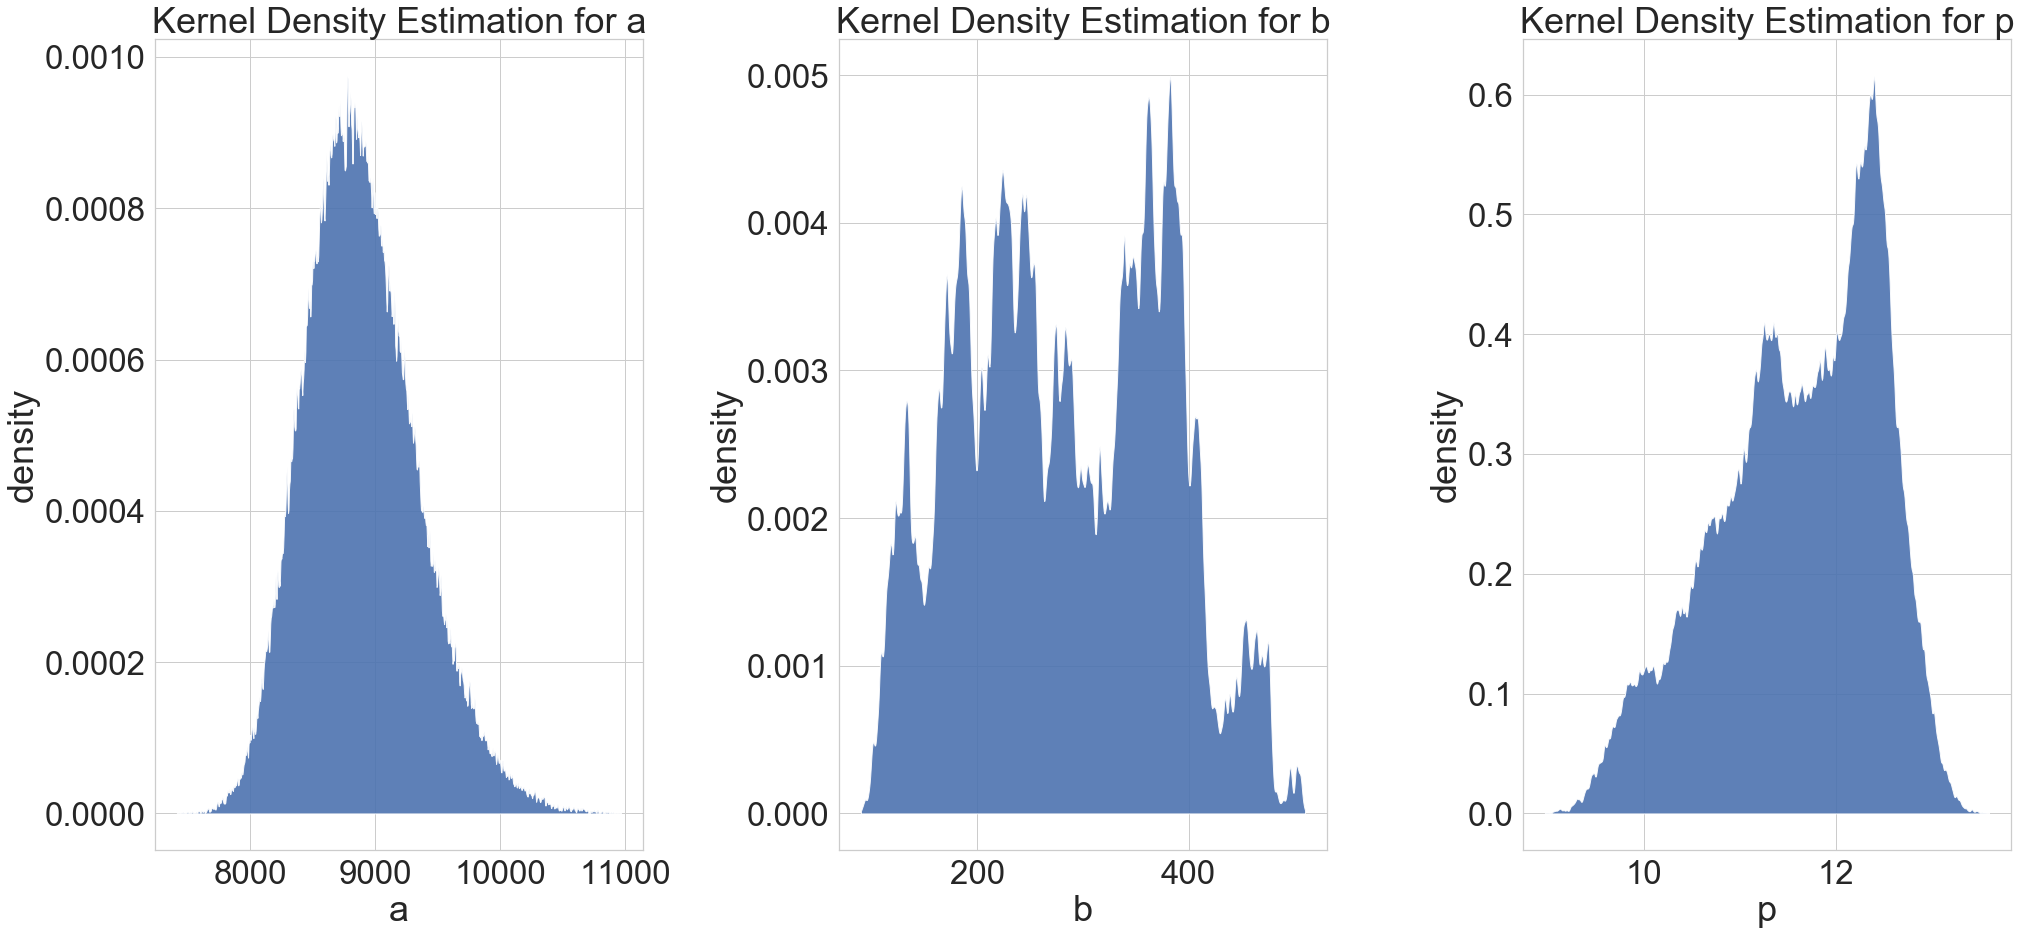

In [47]:
fig = plt.figure(figsize=(30., 15.))
axes = fig.subplots(nrows=1, ncols=3)
fig.tight_layout(pad=3.0)

axes[0].fill_between(x_d_a, np.exp(logprob_a), alpha=0.9)
axes[0].set_title('Kernel Density Estimation for a')                            
axes[0].set_xlabel('a')
axes[0].set_ylabel('density')

axes[1].fill_between(x_d_b, np.exp(logprob_b), alpha=0.9)
axes[1].set_title('Kernel Density Estimation for b')                            
axes[1].set_xlabel('b')
axes[1].set_ylabel('density')

axes[2].fill_between(x_d_p, np.exp(logprob_p), alpha=0.9)
axes[2].set_title('Kernel Density Estimation for p')                            
axes[2].set_xlabel('p')
axes[2].set_ylabel('density')

plt.show()

In [48]:
rep_a = kde_a.sample(5000)
rep_b = kde_b.sample(5000)
rep_p = kde_p.sample(5000)

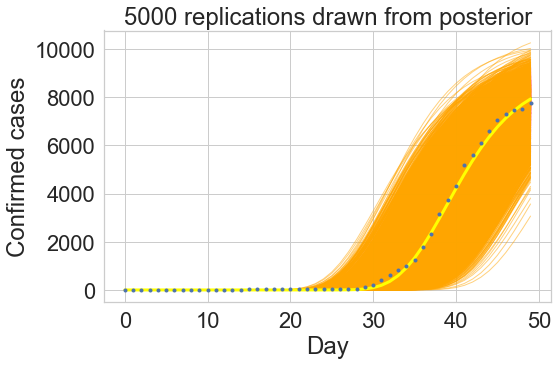

In [49]:
%%capture --no-display
plot_with_model_3(data[:,:50],rep_a,rep_b,rep_p)

# Validation

In [50]:
#calibration posterior
#prior distribution for validation
def prior_c_3(x):
    #x[0] = r, x[1]=p (new or current)
    logprob_a = kde_a.score_samples(x[0].reshape(1,-1))
    logprob_b = kde_b.score_samples(x[1].reshape(1,-1))
    logprob_p = kde_p.score_samples(x[2].reshape(1,-1))
    return np.exp(logprob_a + logprob_b + logprob_p)

In [51]:
%%capture --no-display
transition_model_m3v = lambda x: np.random.normal(x,[1.,0.01,0.001],(3,))
noise_sig = 500.
accepted_m3v, rejected_m3v, itr_a_m3v, itr_r_m3v = metropolis_hastings(log_like_3,prior_c_3,transition_model_m3v,mu_m3c,150000,data[:,50:],acceptance)

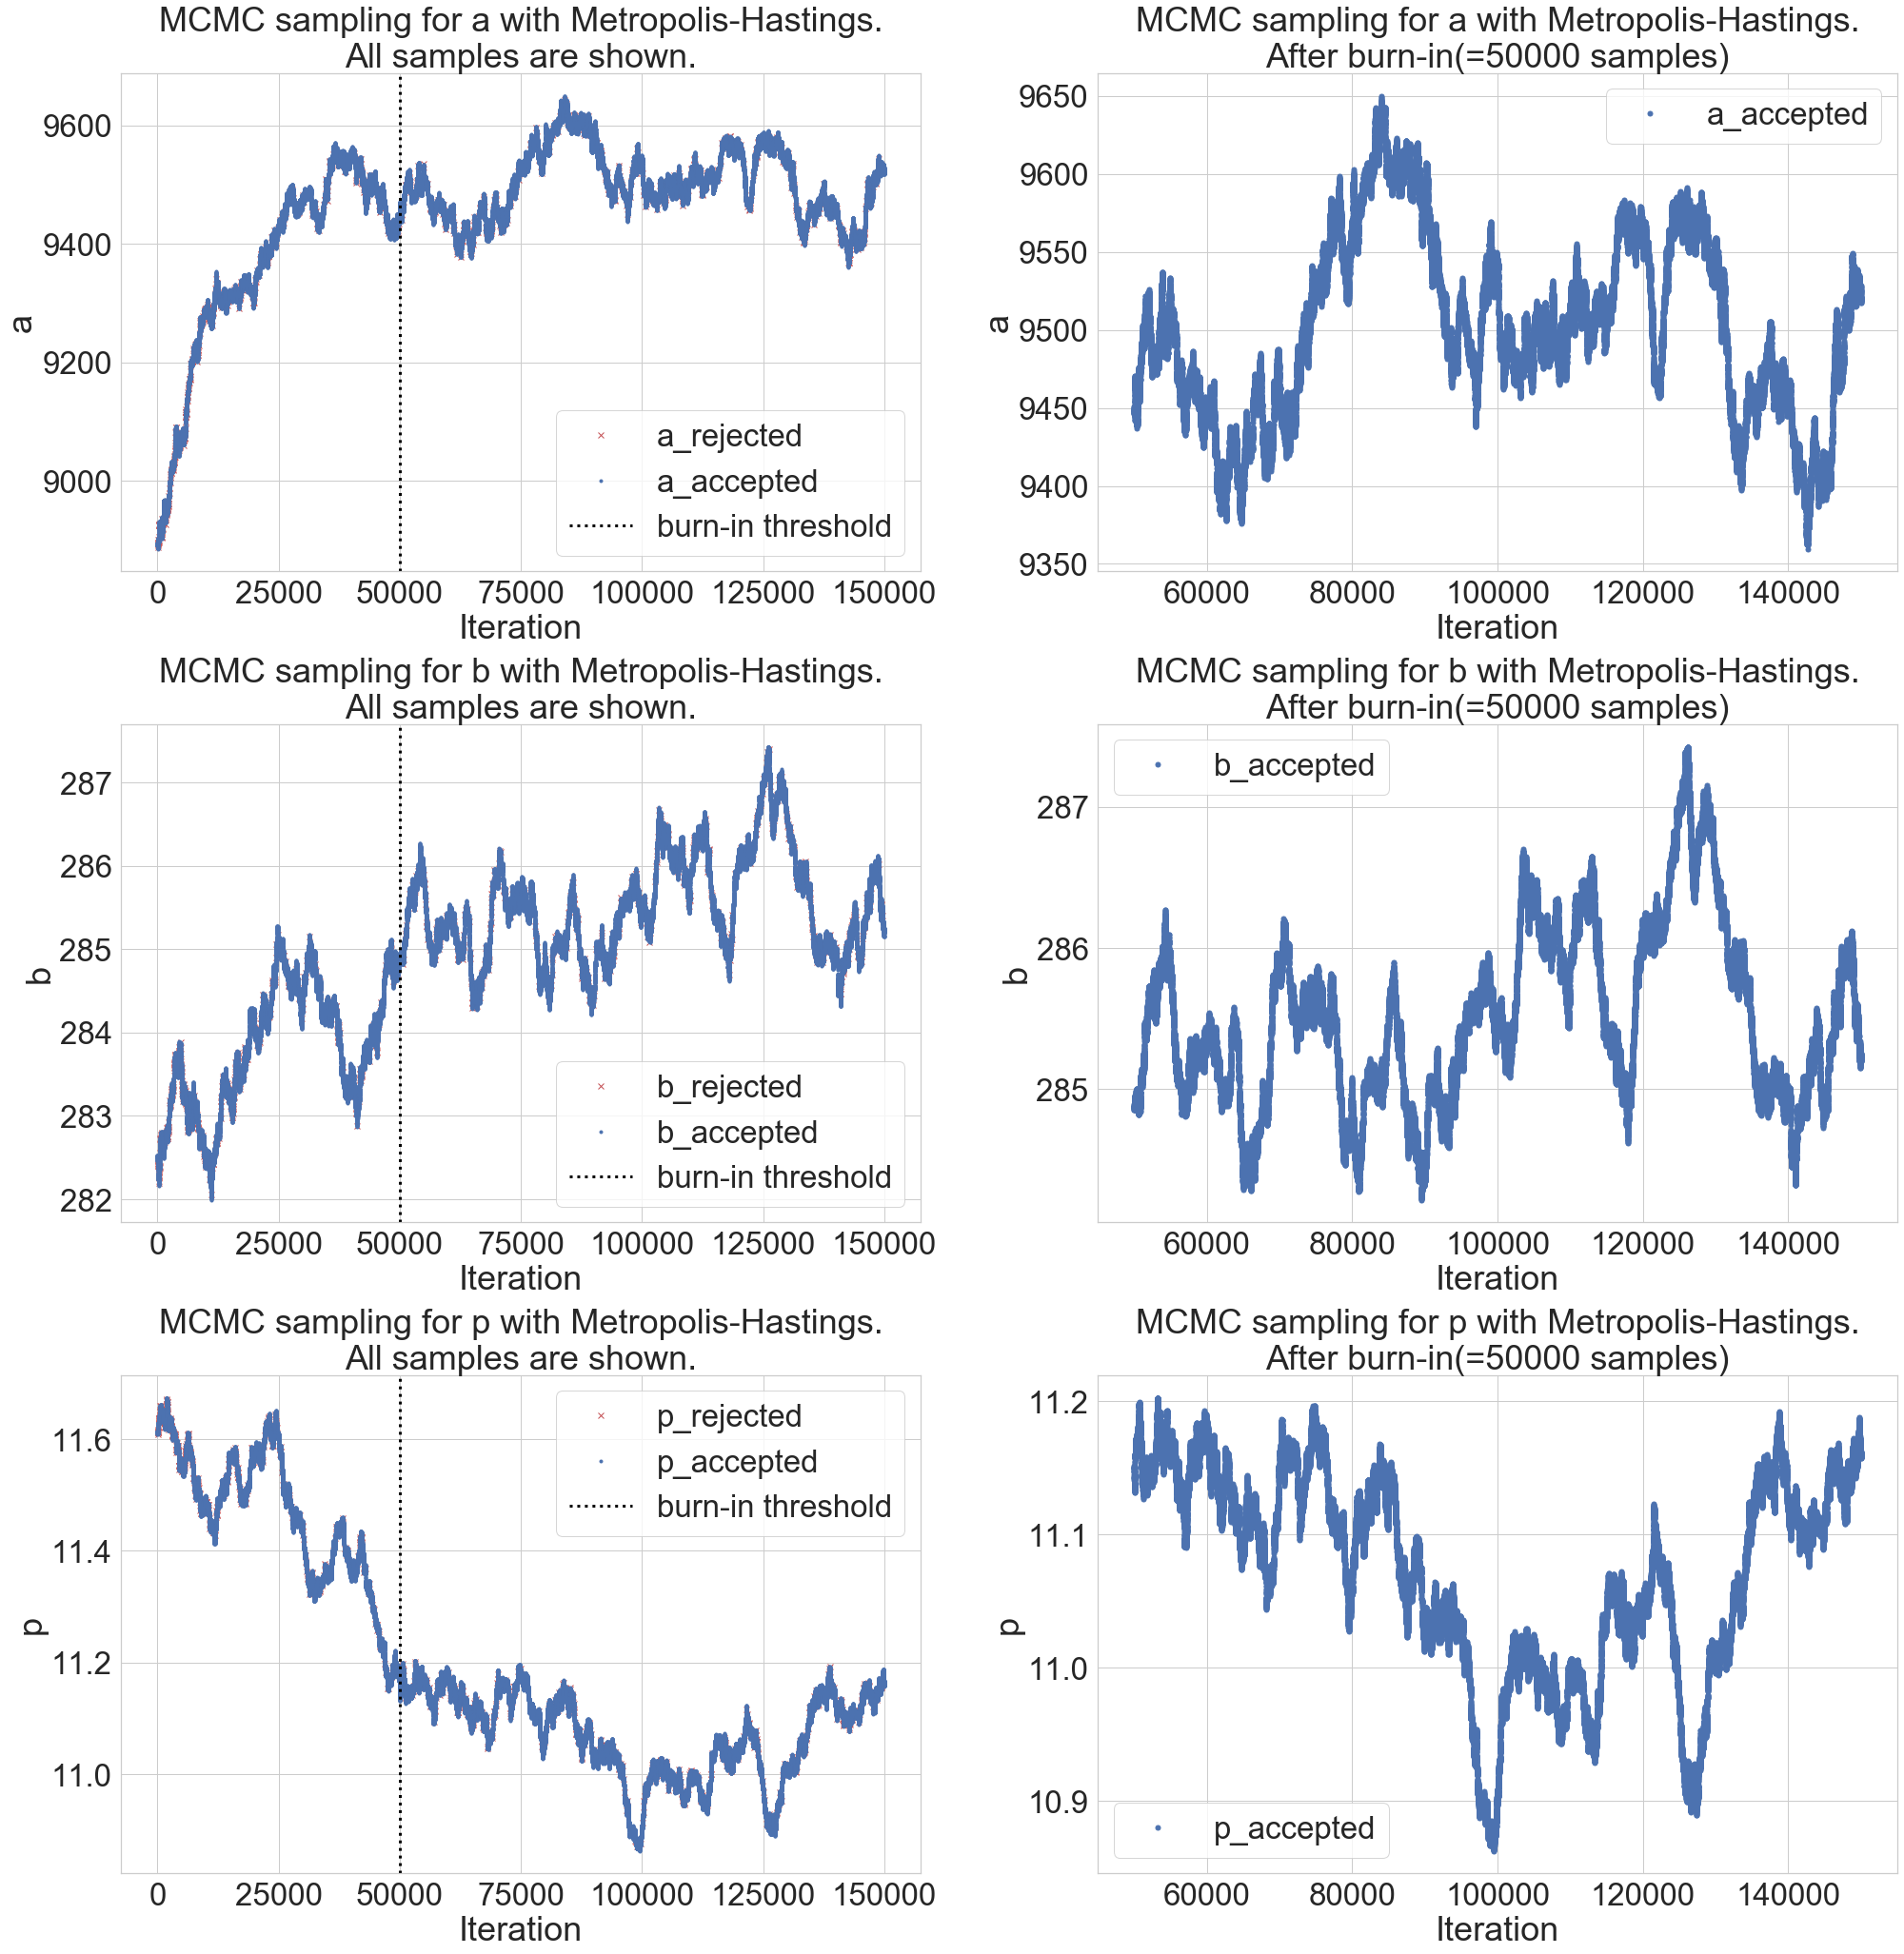

In [52]:
burnin = 50000
plot_MCMC_check_3(accepted_m3v, rejected_m3v, itr_a_m3v, itr_r_m3v, burnin)

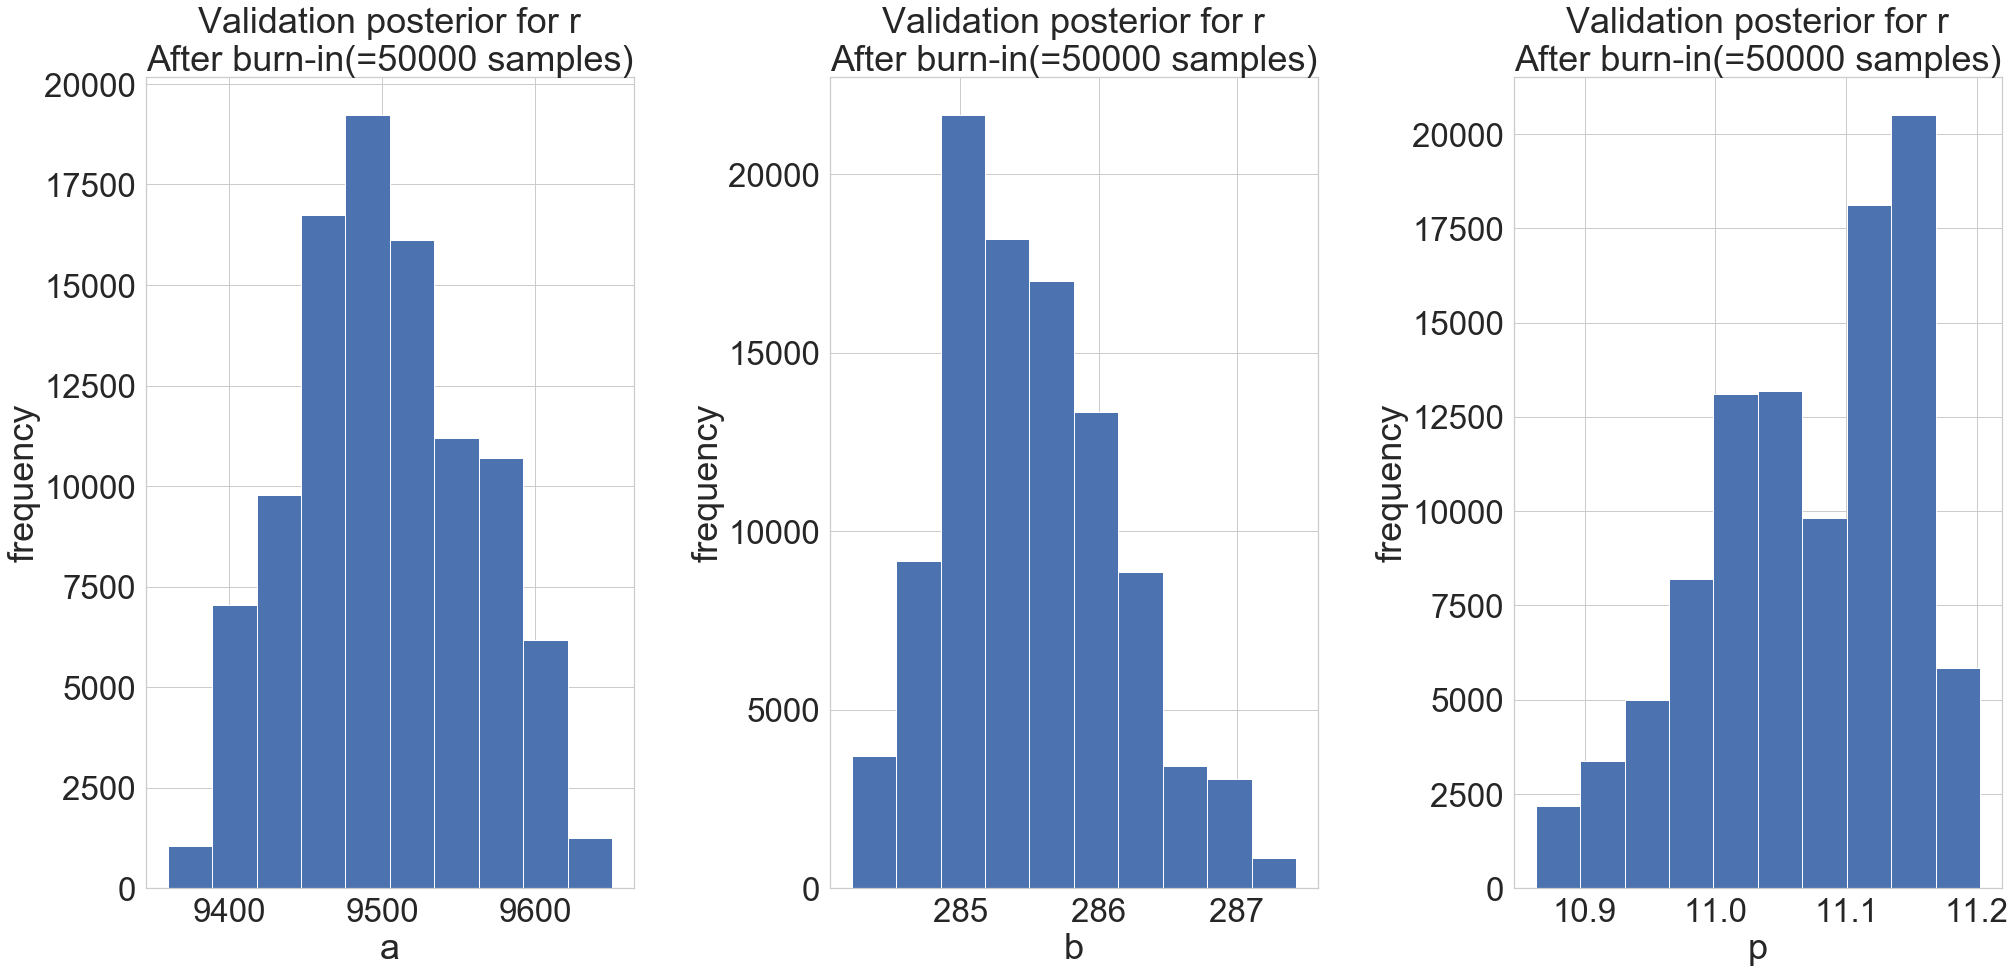

In [53]:
plot_posterior_3(accepted_m3v, itr_a_m3v, burnin, 1)

In [54]:
mu_m3v = [np.mean(accepted_m3v[np.where(itr_a_m3v>burnin)][:,0]),np.mean(accepted_m3v[np.where(itr_a_m3v>burnin)][:,1]),np.mean(accepted_m3v[np.where(itr_a_m3v>burnin)][:,2])]

# Kernel Density Estimation

In [55]:
kde_a = KernelDensity(bandwidth=1.,kernel='gaussian')
x = accepted_m3v[np.where(itr_a_m3v>burnin)][:,0]
kde_a.fit(x[:,None])
x_d_a = np.linspace(min(x),max(x),1000)
logprob_a = kde_a.score_samples(x_d_a[:,None])

In [56]:
kde_b = KernelDensity(bandwidth=0.1,kernel='gaussian')
x = accepted_m3v[np.where(itr_a_m3v>burnin)][:,1]
kde_b.fit(x[:,None])
x_d_b = np.linspace(min(x),max(x),1000)
logprob_b = kde_b.score_samples(x_d_b[:,None])

In [57]:
kde_p = KernelDensity(bandwidth=0.01,kernel='gaussian')
x = accepted_m3v[np.where(itr_a_m3v>burnin)][:,2]
kde_p.fit(x[:,None])
x_d_p = np.linspace(min(x),max(x),1000)
logprob_p = kde_p.score_samples(x_d_p[:,None])

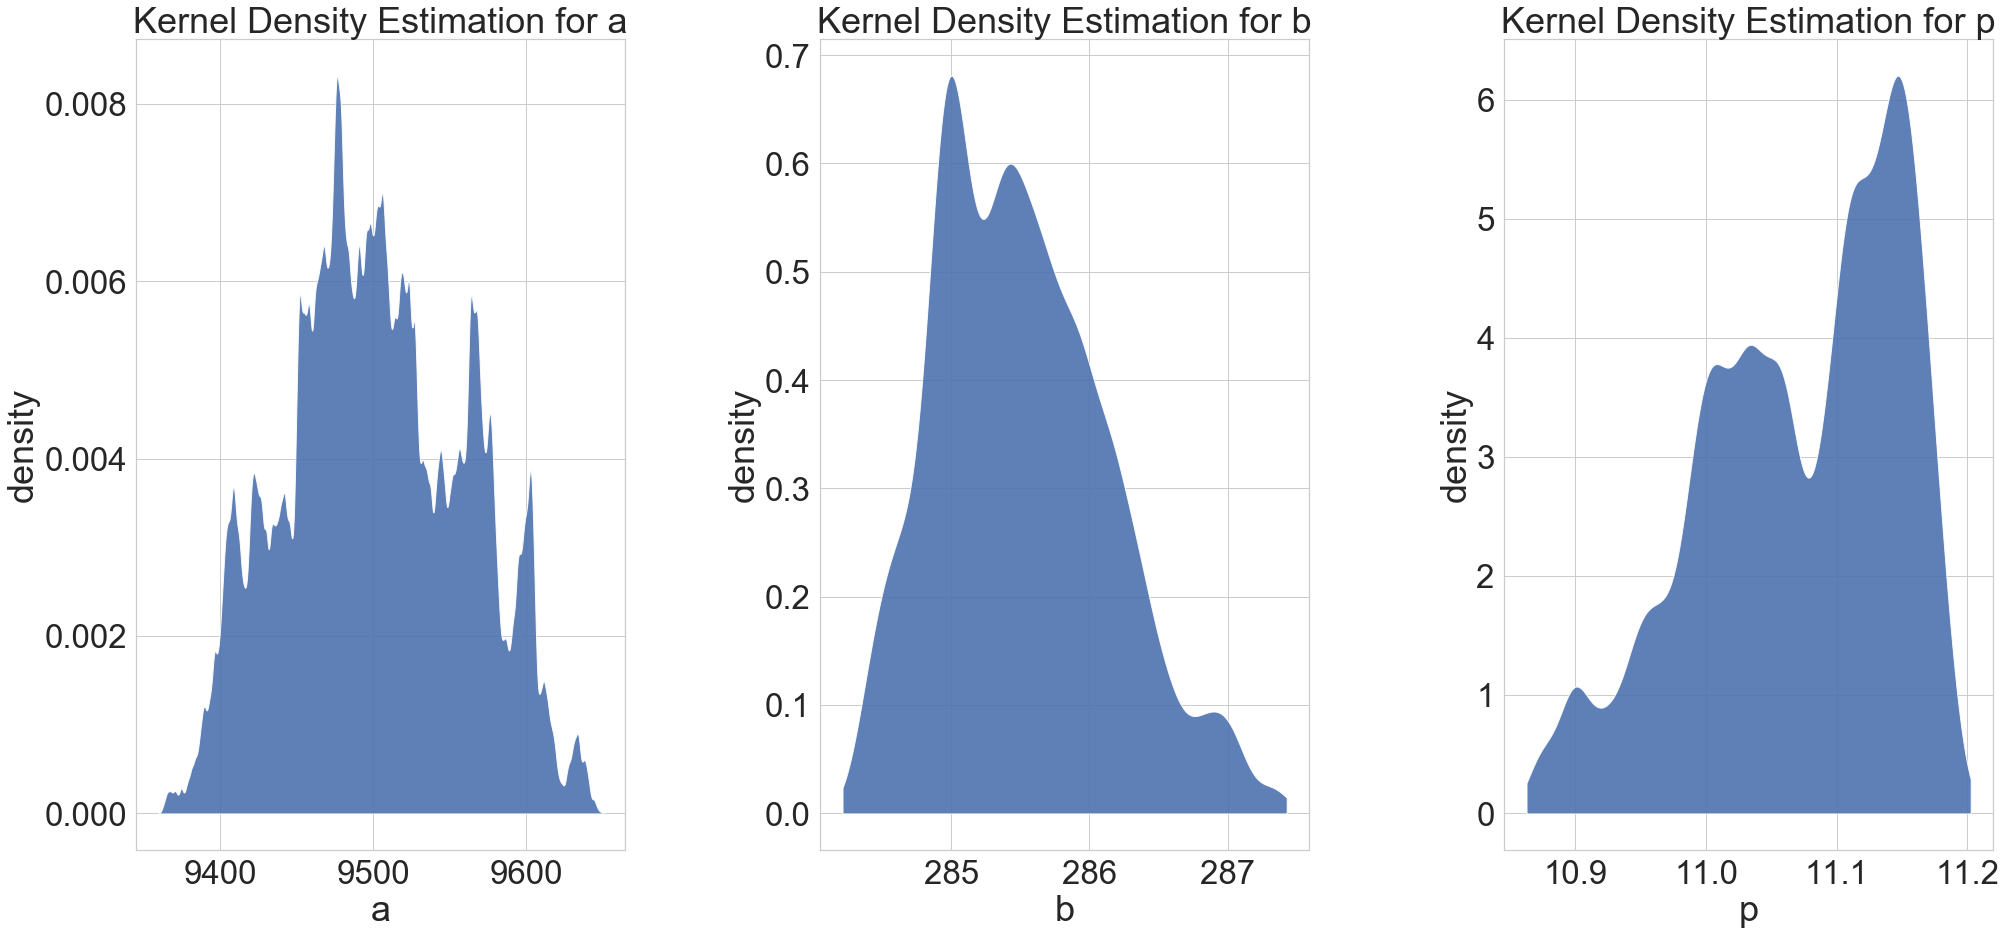

In [58]:
fig = plt.figure(figsize=(30., 15.))
axes = fig.subplots(nrows=1, ncols=3)
fig.tight_layout(pad=3.0)

axes[0].fill_between(x_d_a, np.exp(logprob_a), alpha=0.9)
axes[0].set_title('Kernel Density Estimation for a')                            
axes[0].set_xlabel('a')
axes[0].set_ylabel('density')

axes[1].fill_between(x_d_b, np.exp(logprob_b), alpha=0.9)
axes[1].set_title('Kernel Density Estimation for b')                            
axes[1].set_xlabel('b')
axes[1].set_ylabel('density')

axes[2].fill_between(x_d_p, np.exp(logprob_p), alpha=0.9)
axes[2].set_title('Kernel Density Estimation for p')                            
axes[2].set_xlabel('p')
axes[2].set_ylabel('density')

plt.show()

In [59]:
rep_a = kde_a.sample(5000)
rep_b = kde_b.sample(5000)
rep_p = kde_p.sample(5000)

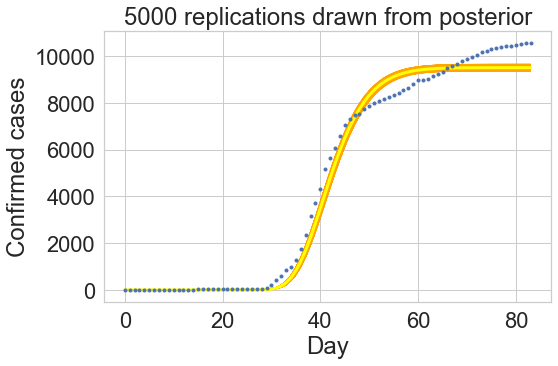

In [60]:
%%capture --no-display
plot_with_model_3(data,rep_a,rep_b,rep_p)

# Validation Metric

In [61]:
np.abs(model_3(data[0,:],np.mean(rep_a),np.mean(rep_b),np.mean(rep_p))[-1] - data[1,-1]) / data[1,-1]

C:\Users\intm2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


0.1004477100344463

# QoI Prediction

In [62]:
QoI = model_3(100,accepted_m3v[np.where(itr_a_m3v>burnin)][:,0],accepted_m3v[np.where(itr_a_m3v>burnin)][:,1],accepted_m3v[np.where(itr_a_m3v>burnin)][:,2])

In [82]:
print(np.mean(QoI))
print(np.std(QoI))

9502.72119721699
57.99012374515935


# Kernel Density Estimation

In [71]:
kde_a = KernelDensity(bandwidth=3.,kernel='gaussian')
x = QoI
kde_a.fit(x[:,None])
x_d_QoI = np.linspace(min(x),max(x),1000)
logprob_QoI = kde_a.score_samples(x_d_QoI[:,None])

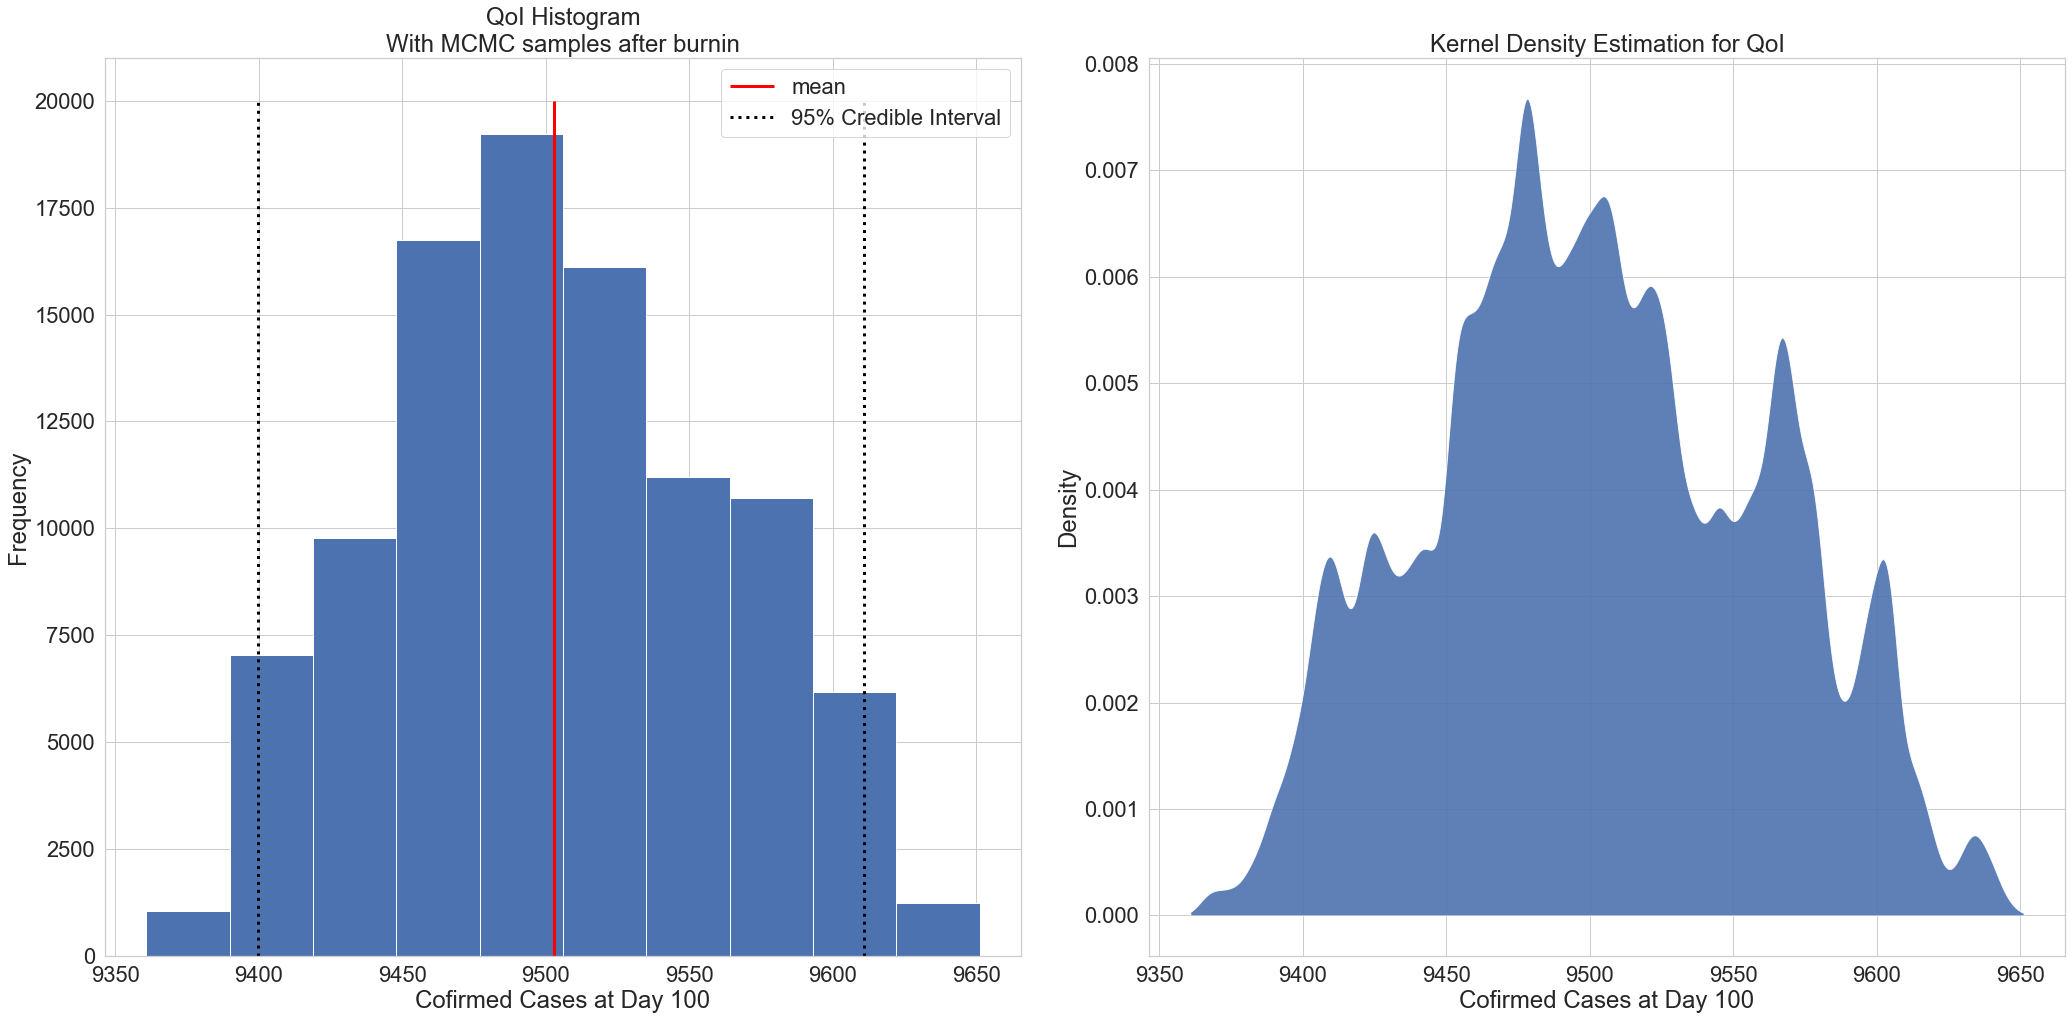

In [81]:
fig = plt.figure(figsize=(30., 15.))
axes = fig.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=3.0)

axes[0].hist(QoI)
axes[0].set_xlabel('Cofirmed Cases at Day 100')
axes[0].set_ylabel('Frequency')
axes[0].vlines(np.mean(QoI),0,20000,color='red',label='mean')
axes[0].vlines(np.quantile(QoI, 0.025),0,20000,color='black',linestyle=':',label='95% Credible Interval')
axes[0].vlines(np.quantile(QoI, 0.975),0,20000,color='black',linestyle=':')
axes[0].set_title('QoI Histogram\nWith MCMC samples after burnin')
axes[0].legend()

axes[1].fill_between(x_d_QoI, np.exp(logprob_QoI), alpha=0.9)
axes[1].set_title('Kernel Density Estimation for QoI')                            
axes[1].set_xlabel('Cofirmed Cases at Day 100')
axes[1].set_ylabel('Density')

plt.show()

# Appendix - Functions

In [67]:
def plot_with_model_3(data,rep_a,rep_b,rep_p):
    import seaborn as sns
    sns.set()
    # sns.set_style("dark")
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})
    
    plt.figure(figsize=(8., 5.))
    for i in range(rep_a.shape[0]):
        plt.plot(data[0],model_3(data[0],rep_a[i],rep_b[i],rep_p[i]),color='orange',alpha=0.5,linewidth=1)
    plt.plot(data[0], model_3(data[0],np.mean(rep_a),np.mean(rep_b),np.mean(rep_p)),color='yellow')
    plt.plot(data[0], data[1],'.')
    plt.title('5000 replications drawn from posterior')
    plt.xlabel('Day')
    plt.ylabel('Confirmed cases')
    plt.show()

In [68]:
def plot_MCMC_check_3(accepted, rejected, itr_a, itr_r, burnin):
    
    import seaborn as sns
    sns.set()
    # sns.set_style("dark")
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 3})
    
    fig = plt.figure(figsize=(30., 30.))
    axes = fig.subplots(nrows=3, ncols=2)
    fig.tight_layout(pad=3.0)

    # plot all samples

    axes[0,0].plot(itr_r, rejected[:,0], 'xr', label='a_rejected')
    axes[0,0].plot(itr_a, accepted[:,0], '.b', label='a_accepted')
    axes[0,0].axvline(x=burnin, linestyle=':', color='black', label='burn-in threshold')
    axes[0,0].set_title('MCMC sampling for a with Metropolis-Hastings.\nAll samples are shown.')                            
    axes[0,0].set_xlabel('Iteration')
    axes[0,0].set_ylabel('a')
    axes[0,0].legend()
    
    axes[1,0].plot(itr_r, rejected[:,1], 'xr', label='b_rejected')
    axes[1,0].plot(itr_a, accepted[:,1], '.b', label='b_accepted')
    axes[1,0].axvline(x=burnin, linestyle=':', color='black', label='burn-in threshold')
    axes[1,0].set_title('MCMC sampling for b with Metropolis-Hastings.\nAll samples are shown.')                            
    axes[1,0].set_xlabel('Iteration')
    axes[1,0].set_ylabel('b')
    axes[1,0].legend()
    
    axes[2,0].plot(itr_r, rejected[:,2], 'xr', label='p_rejected')
    axes[2,0].plot(itr_a, accepted[:,2], '.b', label='p_accepted')
    axes[2,0].axvline(x=burnin, linestyle=':', color='black', label='burn-in threshold')
    axes[2,0].set_title('MCMC sampling for p with Metropolis-Hastings.\nAll samples are shown.')                            
    axes[2,0].set_xlabel('Iteration')
    axes[2,0].set_ylabel('p')
    axes[2,0].legend()
    
    # plot without burn-in samples
    
    axes[0,1].plot(itr_a[np.where(itr_a>burnin)], accepted[np.where(itr_a>burnin)][:,0], '.b', label='a_accepted', markersize=10)
    axes[0,1].set_title('MCMC sampling for a with Metropolis-Hastings.\nAfter burn-in(={} samples)'.format(burnin))                            
    axes[0,1].set_xlabel('Iteration')
    axes[0,1].set_ylabel('a')
    axes[0,1].legend()
    
    axes[1,1].plot(itr_a[np.where(itr_a>burnin)], accepted[np.where(itr_a>burnin)][:,1], '.b', label='b_accepted', markersize=10)
    axes[1,1].set_title('MCMC sampling for b with Metropolis-Hastings.\nAfter burn-in(={} samples)'.format(burnin)) 
    axes[1,1].set_xlabel('Iteration')
    axes[1,1].set_ylabel('b')
    axes[1,1].legend()
    
    axes[2,1].plot(itr_a[np.where(itr_a>burnin)], accepted[np.where(itr_a>burnin)][:,2], '.b', label='p_accepted', markersize=10)
    axes[2,1].set_title('MCMC sampling for p with Metropolis-Hastings.\nAfter burn-in(={} samples)'.format(burnin)) 
    axes[2,1].set_xlabel('Iteration')
    axes[2,1].set_ylabel('p')
    axes[2,1].legend()
        
    plt.show() 

In [69]:
def plot_posterior_3(accepted, itr_a, burnin, cv):
    
    import seaborn as sns
    sns.set()
    # sns.set_style("dark")
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 3})
    
    fig = plt.figure(figsize=(30., 15.))
    axes = fig.subplots(nrows=1, ncols=3)
    fig.tight_layout(pad=3.0)
    
    axes[0].hist(accepted[np.where(itr_a>burnin)][:,0])
    if cv == 0:
        axes[0].set_title('Calibration posterior for r\nAfter burn-in(={} samples)'.format(burnin))                            
    else :
        axes[0].set_title('Validation posterior for r\nAfter burn-in(={} samples)'.format(burnin))                             
    axes[0].set_xlabel('a')
    axes[0].set_ylabel('frequency')
    
    axes[1].hist(accepted[np.where(itr_a>burnin)][:,1])
    if cv == 0:
        axes[1].set_title('Calibration posterior for r\nAfter burn-in(={} samples)'.format(burnin))                            
    else :
        axes[1].set_title('Validation posterior for r\nAfter burn-in(={} samples)'.format(burnin))                             
    axes[1].set_xlabel('b')
    axes[1].set_ylabel('frequency')
    #axes[1].tick_params(axis='x', labelrotation=45)
    
    axes[2].hist(accepted[np.where(itr_a>burnin)][:,2])
    if cv == 0:
        axes[2].set_title('Calibration posterior for r\nAfter burn-in(={} samples)'.format(burnin))                            
    else :
        axes[2].set_title('Validation posterior for r\nAfter burn-in(={} samples)'.format(burnin))                             
    axes[2].set_xlabel('p')
    axes[2].set_ylabel('frequency')
    #axes[1].tick_params(axis='x', labelrotation=45)
        
    plt.show() 